# Simple FEM-BEM coupling for the Helmholtz equation with FEniCSx

## Background
<i>For this problem, you will need FEniCSx installed alongside Bempp. If FEniCSx is not available on your system you can use the Docker image from <a href='http://bempp.com'>bempp.com</a></i>

In this tutorial, we will solve the problem of a wave travelling through a unit cube, $\Omega = [0,1]^3$ with different material parameters inside and outside the domain. The incident wave is given by

$$
u^\text{inc}(\mathbf{x})=\mathrm{e}^{\mathrm{i} k \mathbf{x}\cdot\mathbf{d}},
$$

where $\mathbf{x}=(x,y,z)$ and $\mathbf{d}$ is the direction of the incident wave. In the implementation we use, $\mathbf{d} = \frac{1}{\sqrt{3}}(1,1,1)$.

The PDE is

$$
\Delta u + n(\mathbf{x})^2 k^2 u = 0, \quad \text{ in } \Omega\\
\Delta u + k^2 u = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega
$$

In this example, we use

$$
n(\mathbf{x}) = 0.5
$$
Since the interior wavenumber is constant one could have also used a BEM/BEM coupling approach. However, here we demonstrate the use of FEM for the interior problem using the <a href='http://fenicsproject.org/' target='new'>FEniCSx</a> finite element package.

## FEM Part
In $\Omega$, the FEM part is formulated as

$$
\int_\Omega \nabla u\cdot\nabla v -k^2\int_\Omega n^2uv - \int_{d\Omega} v\frac{\partial u}{\partial \nu} = 0,
$$

or

$$
\langle\nabla u,\nabla v\rangle_\Omega - k^2\langle n^2u,v\rangle_\Omega - \langle \lambda,v\rangle_\Gamma=0,
$$

where $\lambda=\frac{\partial u}{\partial \nu}$.

Later, we will write this as the following operator equation

$$
\mathsf{A}u-k^2 \mathsf{M}u-\mathsf{M}_\Gamma \lambda = 0
$$

## BEM Part
In $\mathbb{R}^3 \backslash \Omega$, we let $u = u^\text{inc}+u^\text{s}$, where $u^\text{inc}$ is the incident wave and $u^\text{s}$ is the scattered wave. As given in <a href='http://epubs.siam.org/doi/book/10.1137/1.9781611973167' target='new'><em>Integral equation methods in scattering theory</em> by Colton & Kress</a>,

$$
0 = \mathcal{K}u^\text{inc}-\mathcal{V}\frac{\partial u^{inc}}{\partial \nu},\\[2mm]
u^\text{s} = \mathcal{K}u^\text{s}-\mathcal{V}\frac{\partial u^{s}}{\partial \nu},
$$
where $\mathcal{K}$ and $\mathcal{V}$ are the double single layer potential operators. Adding these, we get

$$
u^\text{s} = \mathcal{K}u-\mathcal{V}\lambda.
$$

This representation formula will be used to find $u^\text{s}$ for plotting later.

Taking the trace on the boundary gives

$$
u-u^\text{inc} = \left(\tfrac{1}{2}\mathsf{Id}+\mathsf{K}\right)u -\mathsf{V}\lambda.
$$

This rearranges to

$$
u^\text{inc} = \left(\tfrac{1}{2}\mathsf{Id}-\mathsf{K}\right)u+\mathsf{V}\lambda.
$$

## Full Formulation
The full blocked formulation is

$$
\begin{bmatrix}
    \mathsf{A}-k^2 \mathsf{M} & -\mathsf{M}_\Gamma\\
    \tfrac{1}{2}\mathsf{Id}-\mathsf{K} & \mathsf{V}
\end{bmatrix}
\begin{bmatrix}
    u\\
    \lambda
\end{bmatrix}=\begin{bmatrix}
    0\\
    u^\text{inc}
\end{bmatrix}.
$$

This formulation is not stable for all frequencies due to the possibility of interior resonances. But it is sufficient for this example and serves as a blueprint for more complex formulations.

## Implementation
We begin by importing DOLFINx (the FEniCSx python library), UFL (FEniCS's unified form language), MPI, Bempp and NumPy.

In [1]:
import dolfinx
from dolfinx.fem import functionspace, Function
from dolfinx.mesh import create_unit_cube
import dolfinx.geometry
import ufl
from mpi4py import MPI
import bempp_cl.api
import numpy as np

Next, we set the wavenumber ``k`` and the direction ``d`` of the incoming wave.

In [2]:
k = 6.0
d = np.array([1.0, 1.0, 1])
d /= np.linalg.norm(d)

We create a DOLFINx mesh. Later, the boundary mesh will be extracted from this.

In [3]:
mesh = create_unit_cube(MPI.COMM_WORLD, 10, 10, 10)

Next, we make the DOLFINx and Bempp function spaces.

The function ``fenics_to_bempp_trace_data`` will extract the trace space from the DOLFINx space and create the matrix ``trace_matrix``, which maps between the dofs (degrees of freedom) in DOLFINx and bempp_cl.

In [4]:
from bempp_cl.api.external import fenicsx

fenics_space = functionspace(mesh, ("CG", 1))
trace_space, trace_matrix = fenicsx.fenics_to_bempp_trace_data(fenics_space)
bempp_space = bempp_cl.api.function_space(trace_space.grid, "DP", 0)

fem_size = fenics_space.dofmap.index_map.size_global
bem_size = bempp_space.global_dof_count

print("FEM dofs: {0}".format(fem_size))
print("BEM dofs: {0}".format(bem_size))

FEM dofs: 1331
BEM dofs: 1200


We create the boundary operators that we need.

In [5]:
id_op = bempp_cl.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
mass = bempp_cl.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)
dlp = bempp_cl.api.operators.boundary.helmholtz.double_layer(trace_space, bempp_space, bempp_space, k)
slp = bempp_cl.api.operators.boundary.helmholtz.single_layer(bempp_space, bempp_space, bempp_space, k)

We create the DOLFINx function spaces and the function (or in this case constant) ``n``.

In [6]:
u = ufl.TrialFunction(fenics_space)
v = ufl.TestFunction(fenics_space)
n = 0.5

We make the vectors on the right hand side of the formulation.

In [7]:
@bempp_cl.api.complex_callable
def u_inc(x, n, domain_index, result):
    result[0] = np.exp(1j * k * np.dot(x, d))


u_inc = bempp_cl.api.GridFunction(bempp_space, fun=u_inc)

# The rhs from the FEM
rhs_fem = np.zeros(fem_size)
# The rhs from the BEM
rhs_bem = u_inc.projections(bempp_space)
# The combined rhs
rhs = np.concatenate([rhs_fem, rhs_bem])

We are now ready to create a ``BlockedLinearOperator`` containing all four parts of the discretisation of
$$
\begin{bmatrix}
    \mathsf{A}-k^2 \mathsf{M} & -\mathsf{M}_\Gamma\\
    \tfrac{1}{2}\mathsf{Id}-\mathsf{K} & \mathsf{V}
\end{bmatrix}.
$$

In [8]:
from bempp_cl.api.assembly.blocked_operator import BlockedDiscreteOperator
from scipy.sparse.linalg.interface import LinearOperator

blocks = [[None, None], [None, None]]

trace_op = LinearOperator(trace_matrix.shape, lambda x: trace_matrix @ x)

A = fenicsx.FenicsOperator((ufl.inner(ufl.grad(u), ufl.grad(v)) - k**2 * n**2 * ufl.inner(u, v)) * ufl.dx)

blocks[0][0] = A.weak_form()
blocks[0][1] = -trace_matrix.T * mass.weak_form().to_sparse()
blocks[1][0] = (0.5 * id_op - dlp).weak_form() * trace_op
blocks[1][1] = slp.weak_form()

blocked = BlockedDiscreteOperator(np.array(blocks))

Next, we solve the system, then split the solution into the parts assosiated with u and &lambda;. For an efficient solve, preconditioning is required.

In [9]:
from bempp_cl.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from scipy.sparse.linalg import LinearOperator

# Compute the sparse inverse of the Helmholtz operator
# Although it is not a boundary operator we can use
# the SparseInverseDiscreteBoundaryOperator function from
# BEM++ to turn its LU decomposition into a linear operator.
P1 = InverseSparseDiscreteBoundaryOperator(blocked[0, 0].to_sparse().tocsc())

# For the Laplace slp we use a simple mass matrix preconditioner.
# This is sufficient for smaller low-frequency problems.
P2 = InverseSparseDiscreteBoundaryOperator(
    bempp_cl.api.operators.boundary.sparse.identity(bempp_space, bempp_space, bempp_space).weak_form()
)


# Create a block diagonal preconditioner object using the Scipy LinearOperator class
def apply_prec(x):
    """Apply the block diagonal preconditioner"""
    n1 = P1.shape[1]

    res1 = P1.dot(x[:n1])
    res2 = P2.dot(x[n1:])
    return np.concatenate([res1, res2])


p_shape = (P1.shape[0] + P2.shape[0], P1.shape[1] + P2.shape[1])
P = LinearOperator(p_shape, apply_prec, dtype=np.dtype("complex128"))

# Create a callback function to count the number of iterations
it_count = 0


def count_iterations(x):
    global it_count
    it_count += 1


from scipy.sparse.linalg import gmres

soln, info = gmres(blocked, rhs, M=P, callback=count_iterations)

soln_fem = soln[:fem_size]
soln_bem = soln[fem_size:]

print("Number of iterations: {0}".format(it_count))

Number of iterations: 324


Next, we make DOLFINx and Bempp functions from the solution.

In [10]:
# Store the real part of the FEM solution
u = Function(fenics_space)
u.x.array[:] = np.ascontiguousarray(np.real(soln_fem))

# Solution function with dirichlet data on the boundary
dirichlet_data = trace_matrix * soln_fem
dirichlet_fun = bempp_cl.api.GridFunction(trace_space, coefficients=dirichlet_data)

# Solution function with Neumann data on the boundary
neumann_fun = bempp_cl.api.GridFunction(bempp_space, coefficients=soln_bem)

We now evaluate the solution on the slice $z=0.5$ and plot it. For the exterior domain, we use the respresentation formula

$$
u^\text{s} = \mathcal{K}u-\mathcal{V}\frac{\partial u}{\partial \nu}
$$

to evaluate the solution.

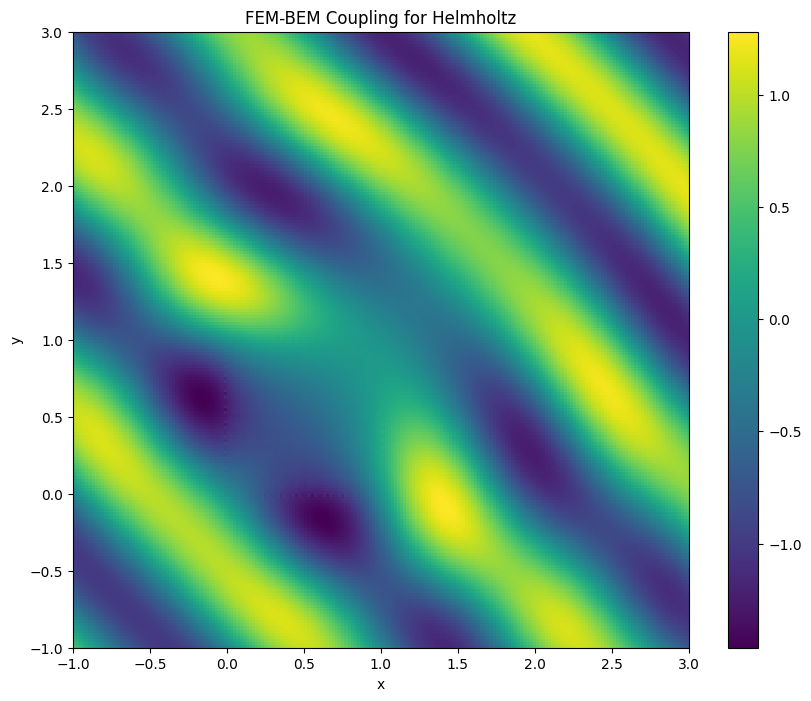

In [11]:
try:
    get_ipython().run_line_magic("matplotlib", "inline")
    ipython = True
except NameError:
    ipython = False

Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-1, 3, -1, 3]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), np.array([0.5] * plot_grid[0].size)))
plot_me = np.zeros(points.shape[1], dtype=np.complex128)

x, y, z = points
bem_x = np.logical_not((x > 0) * (x < 1) * (y > 0) * (y < 1) * (z > 0) * (z < 1))

slp_pot = bempp_cl.api.operators.potential.helmholtz.single_layer(bempp_space, points[:, bem_x], k)
dlp_pot = bempp_cl.api.operators.potential.helmholtz.double_layer(trace_space, points[:, bem_x], k)

plot_me[bem_x] += np.exp(1j * k * (points[0, bem_x] * d[0] + points[1, bem_x] * d[1] + points[2, bem_x] * d[2]))
plot_me[bem_x] += dlp_pot.evaluate(dirichlet_fun).flat
plot_me[bem_x] -= slp_pot.evaluate(neumann_fun).flat

fem_points = points[:, np.logical_not(bem_x)].transpose()
tree = dolfinx.geometry.bb_tree(mesh, 3)
midpoint_tree = dolfinx.geometry.create_midpoint_tree(
    mesh, 3, np.array(list(range(mesh.topology.connectivity(3, 0).num_nodes)))
)
entities = []
for point in fem_points:
    entities.append(dolfinx.geometry.compute_closest_entity(tree, midpoint_tree, mesh, point)[0])
fem_val = u.eval(fem_points, entities)

plot_me[np.logical_not(bem_x)] += fem_val.T[0]

plot_me = plot_me.reshape((Nx, Ny))

plot_me = plot_me.transpose()[::-1]

# Plot the image
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(plot_me), extent=[xmin, xmax, ymin, ymax])
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.title("FEM-BEM Coupling for Helmholtz")
if not ipython:
    plt.savefig("example-simple_helmholtz_fem_bem_coupling_dolfinx.png")